In [2]:
from varyingsim.envs.push_box_offset import PushBoxOffset
from varyingsim.util.learn import *
from varyingsim.algos.BufferedModel import BufferedModel
from varyingsim.models.feed_forward import FeedForward
from varyingsim.models.mujoco_dynamics import MuJoCoDynamics
from varyingsim.datasets.fov_dataset import StartEndDataset

import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt

In [3]:
def qpos_box_loss(qpos_hat, qvel_hat, qpos, qvel):
#     return F.mse_loss(qpos_hat[..., :7].cpu(), qpos[..., :7].cpu()) # for full 6 dof
    return F.mse_loss(qpos_hat[..., :2].cpu(), qpos[..., :2].cpu()) # just xy

## Training using the codebase

In [4]:
algo_options = {
    'hidden_sizes': [2048, 2048],
    'buffer_size': -1,
    'learn_freq': 1,
    'lr': 1e-3,
    'num_iters': 1,
    'batch_size': 64,
    'mixed_loss': False,
    'momentum': 0.9,
    'context_size': 32
}

include_fov = True
device = 'cuda:1'
learn_iters = 120000
print_iter = 500
exp_path = '/data/varyingsim/experiments/push_box_contact/debugging'
dataset_location = '/data/varyingsim/push_box_contact_simple_tiny_1.pickle'

env = PushBoxOffset()
d_obs = env.model.nq + env.model.nv
d_in = d_obs + env.model.nu + (include_fov * env.n_fov)

model = FeedForward(d_in, d_obs, algo_options['hidden_sizes']).to(device)
mujoco_model = MuJoCoDynamics(env, model).to(device)
optim = torch.optim.SGD(mujoco_model.parameters(), lr=float(algo_options['lr']), momentum=algo_options['momentum'])

dataset = StartEndDataset(dataset_location, algo_options['context_size'], include_full=False)

algo = BufferedModel(algo_options['buffer_size'], env, mujoco_model, optim, qpos_box_loss, 
    algo_options['context_size'], device=device, batch_size=algo_options['batch_size'],
    num_iters=algo_options['num_iters'], use_mixed_loss=algo_options['mixed_loss'],
    include_fov=include_fov)

In [5]:
info = learn_iid_fix(algo, dataset, learn_iters, exp_path, print_iter=print_iter, device=device)

losses 0.085861936211586
losses 0.013594764284789562
losses 0.010798386298120022
losses 0.007196369115263224
losses 0.010578418150544167
losses 0.005649446975439787
losses 0.007802298292517662
losses 0.008688116446137428
losses 0.004188661929219961
losses 0.008361273445189
losses 0.006105422042310238
losses 0.008025831542909145
losses 0.00708951149135828
losses 0.0053627765737473965
losses 0.0050038970075547695
losses 0.0060579655691981316
losses 0.003870063228532672
losses 0.004128179978579283
losses 0.005975948181003332
losses 0.004416659474372864
losses 0.004279474727809429
losses 0.005127585493028164
losses 0.004627078305929899
losses 0.005722021218389273
losses 0.004716928116977215
losses 0.004981217905879021
losses 0.0031526051461696625
losses 0.004819342400878668
losses 0.005045931786298752
losses 0.004659848287701607
losses 0.004448192194104195
losses 0.004299867898225784
losses 0.0041214958764612675
losses 0.004907590337097645
losses 0.0036720449570566416
losses 0.002948376117

In [87]:
with open(os.path.join(exp_path, 'algo.pickle'), 'wb') as f:
    algo.save(f)
    
with open(os.path.join(exp_path, 'info.pickle'), 'wb') as f:
    pickle.dump(info, f)
    
print(np.mean(info['test_losses']))

0.002975192037411034


In [103]:
def visualize_fov(model, datum):
    start = datum['obs'][:2]
    end = datum['obs_prime'][:2]
    plt.scatter(start[0], start[1], label='obs_0')
    plt.scatter(end[0], end[1], label='end obs')
    x = torch.tensor([[datum['fov'][0]]]).float().to(device)
    y_hat = model(x).cpu().detach()
    plt.plot([start[0], y_hat[0, 0]], [start[1], y_hat[0, 1]], label='end obs hat')
    plt.legend()
    plt.show()

## By hand

In [70]:
train_x, train_y, test_x, test_y = [], [], [], []
for i, datum in enumerate(dataset):
    if i < 10:
        train_x.append(datum['fov'][0])
        train_y.appe.to(device)nd(datum['obs_prime'][:2])
    else:
        test_x.append(datum['fov'][0])
        test_y.append(datum['obs_prime'][:2])
test_x = np.array(test_x)
train_x = np.array(train_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

for x,y in zip(train_x, train_y):
    print("{:.2f}".format(x), '\t', y)

0.00 	 [-7.41091972e-01 -7.52781542e-18]
0.14 	 [-0.29952981  0.15395955]
-0.03 	 [-0.47045783 -0.1579162 ]
-0.13 	 [-0.2993662  -0.15356839]
0.06 	 [-0.40775856  0.15695039]
0.12 	 [-0.29901114  0.15535901]
-0.09 	 [-0.35800288 -0.15541463]
-0.10 	 [-0.31493663 -0.15514827]
0.12 	 [-0.30799363  0.1548937 ]
0.07 	 [-0.40098938  0.15753543]


In [81]:
mean_x, mean_y = np.mean(train_y, axis=0)
# test_guesses = np.array([[mean_x, mean_y] for x in test_x])
test_guesses = np.array([[mean_x, 0.155 * np.sign(x)] for x in test_x])
train_guesses = np.array([[mean_x, 0.155 * np.sign(x)] for x in train_x])
all_guesses = np.concatenate([train_guesses, test_guesses])

print('train_mse')
print(qpos_box_loss(torch.from_numpy(train_guesses), None, torch.from_numpy(train_y), None).item())

print('test_mse')
print(qpos_box_loss(torch.from_numpy(test_guesses), None, torch.from_numpy(test_y), None).item())

print('all_mse')
print(qpos_box_loss(torch.from_numpy(all_guesses), None, torch.from_numpy(np.concatenate([train_y, test_y])), None).item())
start

train_mse
0.008412948990617912
test_mse
0.014433715553467372
all_mse
0.011423332272042641


## Training separately
### Everythign naiive

In [88]:
model = FeedForward(d_in, d_obs, algo_options['hidden_sizes']).to(device)
mujoco_model = MuJoCoDynamics(env, model).to(device)
optim = torch.optim.SGD(mujoco_model.parameters(), lr=float(algo_options['lr']), momentum=algo_options['momentum'])

loader = DataLoader(dataset, batch_size = algo_options['batch_size'])
i = 0
for i in range(learn_iters):
    for batch in loader:
        obs = batch['obs'].float().to(device)
        act = batch['act'].float().to(device)
        fov = batch['fov'].float().to(device)
        obs_prime = batch['obs_prime'].float().to(device)

        qpos, qvel = torch.split(obs, 9, dim=-1)
        optim.zero_grad()
        qpos_prime_hat, qvel_prime_hat = mujoco_model(qpos, qvel, act, extra=fov)
        loss = qpos_box_loss(qpos_prime_hat, None, obs_prime, None)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(i, loss.item())



0 0.08966910094022751
100 0.015979837626218796
200 0.014339886605739594
300 0.013309505768120289
400 0.012610971927642822
500 0.01212958712130785
600 0.011787435039877892
700 0.011537030339241028
800 0.01133972592651844
900 0.011177122592926025
1000 0.011035238392651081
1100 0.010898696258664131
1200 0.010774814523756504
1300 0.010655663907527924
1400 0.010539993643760681
1500 0.010425538755953312
1600 0.010311064310371876
1700 0.010196588933467865
1800 0.010084709152579308
1900 0.009971359744668007
2000 0.009858685545623302
2100 0.009746493771672249
2200 0.00963558815419674
2300 0.009526452980935574
2400 0.009417225606739521
2500 0.009308961220085621
2600 0.009202172048389912
2700 0.009095422923564911
2800 0.008990779519081116
2900 0.00888713076710701
3000 0.008781841024756432
3100 0.008680025115609169
3200 0.008580626919865608
3300 0.0084828557446599
3400 0.008385280147194862
3500 0.008289484307169914
3600 0.008197329938411713
3700 0.008104533888399601
3800 0.008015375584363937
3900 

## Simple inputs and outputs

In [119]:
def train_simple(hidden_sizes, lr, momentum, batch_size, model=None):
    model = FeedForward(1, 2, hidden_sizes).to(device) if model is None else model
    optim = torch.optim.SGD(model.parameters(), lr=float(lr), momentum=momentum)
#     optim = torch.optim.Adam(model.parameters(), lr=float(lr))


    loader = DataLoader(dataset, batch_size = batch_size)
    i = 0
    
    losses = []
    for i in range(learn_iters):
        for batch in loader:
            fov = batch['fov'].float().to(device)
            obs_prime = batch['obs_prime'].float().to(device)

            x = fov[:, 0:1]
            y = obs_prime[:, :2]

            optim.zero_grad()
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            loss.backward()
            optim.step()
            if i % 100 == 0:
                print(i, loss.item())
            losses.append(loss.item())
    
    return losses, model



In [ ]:
losses, simple_model = train_simple(algo_options['hidden_sizes'], algo_options['lr'], algo_options['momentum'], algo_options['batch_size'])

In [120]:
# losses, simple_model = train_simple(algo_options['hidden_sizes'], algo_options['lr'], algo_options['momentum'], algo_options['batch_size'], model=simple_model)

0 0.002057596342638135
100 0.0020529571920633316
200 0.0020477029029279947
300 0.002042532665655017
400 0.002038339851424098
500 0.0020328378304839134
600 0.002027982845902443
700 0.002023226348683238
800 0.0020179757848381996
900 0.0020128521136939526
1000 0.0020076939836144447
1100 0.0020024513360112906
1200 0.0019972403533756733
1300 0.001992401434108615
1400 0.001987591851502657
1500 0.0019816725980490446
1600 0.00197709072381258
1700 0.001972125843167305
1800 0.001967083662748337
1900 0.0019617192447185516
2000 0.0019561226945370436
2100 0.0019515486201271415
2200 0.0019472547573968768
2300 0.001941801281645894
2400 0.0019369814544916153
2500 0.0019317949190735817
2600 0.0019265701994299889
2700 0.001921505550853908
2800 0.0019158695358783007
2900 0.0019112633308395743
3000 0.001907238969579339
3100 0.0019019537139683962
3200 0.0018967287614941597
3300 0.0018920699367299676
3400 0.001887198188342154
3500 0.0018818367971107364
3600 0.0018766261637210846
3700 0.0018723373068496585
3

30000 0.0009577505406923592
30100 0.0009562220657244325
30200 0.0009542195475660264
30300 0.0009519299492239952
30400 0.000950084940996021
30500 0.0009488213690929115
30600 0.0009469205397181213
30700 0.0009446878102608025
30800 0.0009438758715987206
30900 0.0009416944230906665
31000 0.0009396121022291481
31100 0.0009381199488416314
31200 0.000936238095164299
31300 0.0009348161402158439
31400 0.0009330190951004624
31500 0.0009317560470663011
31600 0.0009298354270868003
31700 0.0009275995544157922
31800 0.000925410189665854
31900 0.00092403928283602
32000 0.0009233218734152615
32100 0.0009208598057739437
32200 0.0009197969338856637
32300 0.0009186603128910065
32400 0.0009170303237624466
32500 0.0009144595242105424
32600 0.0009126307559199631
32700 0.0009110026294365525
32800 0.0009096978465095162
32900 0.0009087141952477396
33000 0.0009070828673429787
33100 0.000905998982489109
33200 0.000904228538274765
33300 0.0009022202575579286
33400 0.0009015124524012208
33500 0.0009000789723359048

59400 0.0006576764862984419
59500 0.000656833581160754
59600 0.0006564960931427777
59700 0.0006559333996847272
59800 0.000655821175314486
59900 0.0006547141238115728


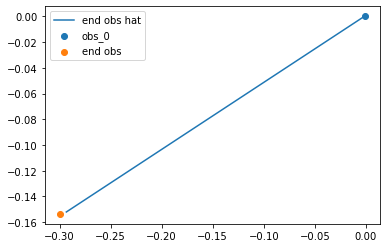

{'hidden_sizes': [2048, 2048], 'buffer_size': -1, 'learn_freq': 1, 'lr': 0.001, 'num_iters': 1, 'batch_size': 64, 'mixed_loss': False, 'momentum': 0.9, 'context_size': 32}


In [126]:
visualize_fov(simple_model, dataset[3])
print(algo_options)

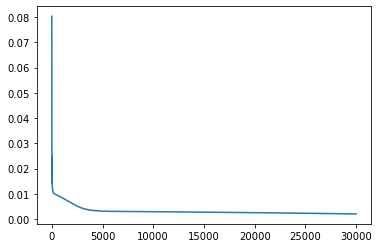

In [111]:
plt.plot(losses)
plt.show()

## LR search

In [34]:
lrs =  [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_losses = []

In [35]:
for lr in lrs:
    print("*******************************")
    print("lr:", lr)
    losses = train_simple(algo_options['hidden_sizes'], lr, algo_options['momentum'], algo_options['batch_size'])
    all_losses.append(losses)

*******************************
lr: 0.01
0 0.09850161522626877
100 0.00938933715224266
200 0.007488552015274763
300 0.00529556954279542
400 0.003810238093137741
500 0.0032740288879722357
600 0.003144149435684085
700 0.003098647575825453
800 0.0030670389533042908
900 0.003036044305190444
1000 0.003005836857482791
1100 0.002974513918161392
1200 0.0029414237942546606
1300 0.0029079222586005926
1400 0.002873496152460575
1500 0.002836940111592412
1600 0.002800059737637639
1700 0.0027612110134214163
1800 0.002721216529607773
1900 0.002677736571058631
2000 0.002634576056152582
2100 0.0025890811812132597
2200 0.002542274072766304
2300 0.0024929519277065992
2400 0.0024429988116025925
2500 0.0023921136744320393
2600 0.00233918777666986
2700 0.0022859114687889814
2800 0.0022307804320007563
2900 0.002173810498788953
3000 0.0021191281266510487
3100 0.0020626652985811234
3200 0.002005739137530327
3300 0.0019503117073327303
3400 0.0018954729894176126
3500 0.0018383454298600554
3600 0.0017852925229817

29600 0.000433915585745126
29700 0.0004342421016190201
29800 0.00043296333751641214
29900 0.00043204324902035296
*******************************
lr: 0.001
0 0.1609351634979248
100 0.010847577825188637
200 0.009960745461285114
300 0.009672792628407478
400 0.009458173997700214
500 0.009248633868992329
600 0.009039731696248055
700 0.008825170807540417
800 0.008602211251854897
900 0.008374810218811035
1000 0.008144401013851166
1100 0.007908946834504604
1200 0.007671143393963575
1300 0.007432323880493641
1400 0.007190370466560125
1500 0.006948576774448156
1600 0.0067086066119372845
1700 0.0064696683548390865
1800 0.006233936175704002
1900 0.006003482732921839
2000 0.0057779583148658276
2100 0.005560183431953192
2200 0.005349605809897184
2300 0.0051484922878444195
2400 0.004955977201461792
2500 0.004775643814355135
2600 0.004606845322996378
2700 0.004448078107088804
2800 0.004300755448639393
2900 0.0041657062247395515
3000 0.0040416414849460125
3100 0.003928696271032095
3200 0.00382662937045

29800 0.0020017081405967474
29900 0.0019958249758929014
*******************************
lr: 0.0001
0 0.11556333303451538
100 0.01719032973051071
200 0.015381920151412487
300 0.01429843157529831
400 0.013512926176190376
500 0.012915673665702343
600 0.012424533255398273
700 0.012024997733533382
800 0.011690057814121246
900 0.011405184864997864
1000 0.01116680447012186
1100 0.010964038781821728
1200 0.010794034227728844
1300 0.010649831965565681
1400 0.010526401922106743
1500 0.010418782010674477
1600 0.010328846052289009
1700 0.010250693187117577
1800 0.010179002769291401
1900 0.010117153637111187
2000 0.01006204355508089
2100 0.010012071579694748
2200 0.009967234916985035
2300 0.009926468133926392
2400 0.009888172149658203
2500 0.009852501563727856
2600 0.009817873127758503
2700 0.009785679168999195
2800 0.009756158106029034
2900 0.009727505967020988
3000 0.009700272232294083
3100 0.00967456866055727
3200 0.009649273939430714
3300 0.00962473638355732
3400 0.009599928744137287
3500 0.009

400 0.019078213721513748
500 0.018718836829066277
600 0.018385302275419235
700 0.01807495951652527
800 0.017780855298042297
900 0.017511580139398575
1000 0.017256636172533035
1100 0.017013629898428917
1200 0.016775844618678093
1300 0.016548488289117813
1400 0.016332879662513733
1500 0.016133010387420654
1600 0.015945542603731155
1700 0.01576925627887249
1800 0.015600591897964478
1900 0.01543965470045805
2000 0.015291847288608551
2100 0.015148654580116272
2200 0.015014645643532276
2300 0.014884145930409431
2400 0.014759677462279797
2500 0.01464206911623478
2600 0.014530307613313198
2700 0.014422038570046425
2800 0.01431873720139265
2900 0.014218265190720558
3000 0.014121373184025288
3100 0.0140287009999156
3200 0.013936561532318592
3300 0.013851235620677471
3400 0.013766609132289886
3500 0.013684800826013088
3600 0.013605648651719093
3700 0.013528227806091309
3800 0.013453629799187183
3900 0.013381672091782093
4000 0.013310444541275501
4100 0.013241690583527088
4200 0.013174797408282757

1400 0.025709068402647972
1500 0.024617958813905716
1600 0.023740103468298912
1700 0.023028571158647537
1800 0.022449199110269547
1900 0.021982872858643532
2000 0.021598948165774345
2100 0.021280450746417046
2200 0.021022794768214226
2300 0.020805800333619118
2400 0.020622340962290764
2500 0.020470159128308296
2600 0.02033994160592556
2700 0.020222673192620277
2800 0.020124835893511772
2900 0.02003856934607029
3000 0.01996001973748207
3100 0.019887728616595268
3200 0.019822366535663605
3300 0.01976216398179531
3400 0.019704675301909447
3500 0.019654063507914543
3600 0.01960214041173458
3700 0.019554277881979942
3800 0.01950801908969879
3900 0.019462883472442627
4000 0.01941961981356144
4100 0.019377591088414192
4200 0.019336793571710587
4300 0.01929473504424095
4400 0.01925544999539852
4500 0.01921413280069828
4600 0.01917431131005287
4700 0.01913553848862648
4800 0.019096283242106438
4900 0.01905832253396511
5000 0.01902185194194317
5100 0.018985476344823837
5200 0.018948400393128395


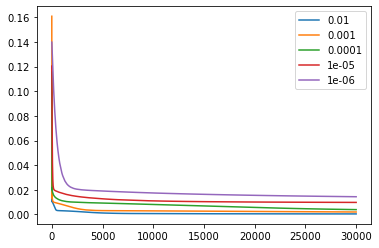

In [43]:

for lr, losses in zip(lrs, all_losses):
    plt.plot(losses, label=str(lr))
plt.legend()
plt.show()

In [45]:
print([losses[-1] for losses in all_losses])

[0.00043129842379130423, 0.0019906775560230017, 0.003922333475202322, 0.00977259874343872, 0.01438390463590622]
